# TABLE OF CONTENT
1. [Gathering data](#gathering-data)
2. [Assesing data](#assessing-data)
3. [Cleaning data](#cleaning)
4. [Store data](#store-data)
5. [Analysis and Visualization](#analysis-and-visualization)

In [105]:
# Import necessary libraries
import warnings
warnings.filterwarnings("ignore")
from typing import List

import re
import pandas as pd
import numpy as np
import seaborn as sns
import requests
from PIL import Image


import tweepy
from tweepy import OAuthHandler
import json

pd.set_option("display.max_columns",60)
pd.set_option("display.max_rows",60)
pd.set_option("display.max_colwidth", 100)

sns.set_style(style="darkgrid")


In [106]:
def any_null(data: pd.DataFrame) -> bool:
    """Checks if there are any null values in the dataframe

    Args:
        data (pd.DataFrame): Dataframe to be checked

    Returns:
        Boolean: True if there are empty values else False
    """
    return data.isna().sum().any()


def new_line_check(data: pd.DataFrame, column: str) -> bool:
    """Checks if the special character for the new line (\\n) is present in the text of a column.

    Args:
        data (pd.DataFrame): Dataframe to be checked
        column (str): Column in dataframe to be checked

    Returns:
        bool: Returns True if there is a \\n any of the values in the column from the dataset
    """
    for index, features in data.iterrows():
        if "\n" in features[column]:
            return True
    return False

def drop_idx(data: pd.DataFrame, column: str, omnipresent_ids: List[int]):
    """Drop tweets where tweet ids not in a omnipresent ids list

    Args:
        data (pd.DataFrame): Dataframe in context
        column (str): tweet id column
        omnipresent_ids (List[int]): Common ids
    """

    index_to_drop = data.query(f"~{column}.isin({omnipresent_ids})").index.tolist()
    data.drop(index_to_drop,inplace=True)
    data.reset_index(drop=True,inplace=True)

### Gathering data

<a id="gathering-data"></a>

In [107]:
# Import enchanced df
enchanced = pd.read_csv("twitter-archive-enhanced.csv")
enchanced_df = enchanced.copy()

In [108]:
# Get images_prediction.tsv 

image_prediction = requests.get("https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv")

with open("image_prediction.tsv","wb") as file:
    file.write(image_prediction.content)

prediction = pd.read_csv("image_prediction.tsv", sep="\t")
prediction_df = prediction.copy()

I wasn't able to get my twitter developer account approved so I had to download the data from [Udacity](https://classroom.udacity.com/nanodegrees/nd002-alg-t2/parts/cd0015/modules/d9096168-9307-4d7f-8731-f07fa3cfbca4/lessons/ls2232/concepts/e7279c35-6d40-42e5-998d-9062ceac6d4c) to use it. The next two cells are codes from [tweepy.py](https://video.udacity-data.com/topher/2018/November/5be5fb4c_twitter-api/twitter-api.py) modified to use the magic ipython command `%%timeit` instead of importing the function.

In [109]:
# # Query Twitter API for each tweet in the Twitter archive and save JSON in a text file
# # These are hidden to comply with Twitter's API terms and conditions
# consumer_key = 'HIDDEN'
# consumer_secret = 'HIDDEN'
# access_token = 'HIDDEN'
# access_secret = 'HIDDEN'

# auth = OAuthHandler(consumer_key, consumer_secret)
# auth.set_access_token(access_token, access_secret)

# api = tweepy.API(auth, wait_on_rate_limit=True)

# # NOTE TO STUDENT WITH MOBILE VERIFICATION ISSUES:
# # df_1 is a DataFrame with the twitter_archive_enhanced.csv file. You may have to
# # change line 17 to match the name of your DataFrame with twitter_archive_enhanced.csv
# # NOTE TO REVIEWER: this student had mobile verification issues so the following
# # Twitter API code was sent to this student from a Udacity instructor
# # Tweet IDs for which to gather additional data via Twitter's API
# tweet_ids = enchanced_df.tweet_id.values
# len(tweet_ids)

In [110]:
# %%timeit
# # Query Twitter's API for JSON data for each tweet ID in the Twitter archive
# count = 0
# fails_dict = {}
# # Save each tweet's returned JSON as a new line in a .txt file
# with open('tweet-json.txt', 'w') as outfile:
#     # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
#     for tweet_id in tweet_ids:
#         count += 1
#         print(str(count) + ": " + str(tweet_id))
#         try:
#             tweet = api.get_status(tweet_id, tweet_mode='extended')
#             print("Success")
#             json.dump(tweet._json, outfile)
#             outfile.write('\n')
#         except tweepy.TweepError as e:
#             print("Fail")
#             fails_dict[tweet_id] = e
#             pass
# print(fails_dict)

In [111]:
# import downloaded twitter account
extracted = pd.read_json("tweet-json.txt",lines=True)
extracted_df = extracted.copy()

### Assessing data

<a id="assessing-data"></a>

In [112]:
enchanced_df

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available fo...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know w...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD3...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and sh...",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/st...",12,10,Franklin,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a 1949 1st generation vulpix. Enjoys sweat tea and Fox News. Cannot be phased. 5/10...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248165822465/photo/1,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a purebred Piers Morgan. Loves to Netflix and chill. Always looks like he forgot to unpl...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226329800704/photo/1,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here is a very happy pup. Big fan of well-maintained decks. Just look at that tongue. 9/10 would...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412701032449/photo/1,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a western brown Mitsubishi terrier. Upset about leaf. Actually 2 dogs here. 7/10 would w...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285002620928/photo/1,7,10,a,None,None,None,None


In [113]:
enchanced_df.name.unique()

array(['Phineas', 'Tilly', 'Archie', 'Darla', 'Franklin', 'None', 'Jax',
       'Zoey', 'Cassie', 'Koda', 'Bruno', 'Ted', 'Stuart', 'Oliver',
       'Jim', 'Zeke', 'Ralphus', 'Canela', 'Gerald', 'Jeffrey', 'such',
       'Maya', 'Mingus', 'Derek', 'Roscoe', 'Waffles', 'Jimbo', 'Maisey',
       'Lilly', 'Earl', 'Lola', 'Kevin', 'Yogi', 'Noah', 'Bella',
       'Grizzwald', 'Rusty', 'Gus', 'Stanley', 'Alfy', 'Koko', 'Rey',
       'Gary', 'a', 'Elliot', 'Louis', 'Jesse', 'Romeo', 'Bailey',
       'Duddles', 'Jack', 'Emmy', 'Steven', 'Beau', 'Snoopy', 'Shadow',
       'Terrance', 'Aja', 'Penny', 'Dante', 'Nelly', 'Ginger', 'Benedict',
       'Venti', 'Goose', 'Nugget', 'Cash', 'Coco', 'Jed', 'Sebastian',
       'Walter', 'Sierra', 'Monkey', 'Harry', 'Kody', 'Lassie', 'Rover',
       'Napolean', 'Dawn', 'Boomer', 'Cody', 'Rumble', 'Clifford',
       'quite', 'Dewey', 'Scout', 'Gizmo', 'Cooper', 'Harold', 'Shikha',
       'Jamesy', 'Lili', 'Sammy', 'Meatball', 'Paisley', 'Albus',
       'Nept

> Notice the `NaN`s all over the dataset, Notice the `None`,`a`,`such`,`quite`,`his`, etc under the `name` column, these are obviously not dog names. 

In [114]:
prediction_df

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True


> Looking at the dataframe, it looks like there is no problem. I thought they said perfect data is a myth🤔? (spoiler alert: wait for it.)

In [115]:
extracted_df

,created_at,id,id_str,full_text,truncated,display_text_range,entities,extended_entities,source,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,in_reply_to_screen_name,user,geo,coordinates,place,contributors,is_quote_status,retweet_count,favorite_count,favorited,retweeted,possibly_sensitive,possibly_sensitive_appealable,lang,retweeted_status,quoted_status_id,quoted_status_id_str,quoted_status
0,2017-08-01 16:23:56+00:00,892420643555336193,892420643555336192,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t....,False,"[0, 85]","{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [], 'media': [{'id': 89242063948687...","{'media': [{'id': 892420639486877696, 'id_str': '892420639486877696', 'indices': [86, 109], 'med...","<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",NaN,NaN,NaN,NaN,None,"{'id': 4196983835, 'id_str': '4196983835', 'name': 'WeRateDogs™ (author)', 'screen_name': 'dog_r...",NaN,NaN,None,NaN,False,8853,39467,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN
1,2017-08-01 00:17:27+00:00,892177421306343426,892177421306343424,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available fo...",False,"[0, 138]","{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [], 'media': [{'id': 89217741319462...","{'media': [{'id': 892177413194625024, 'id_str': '892177413194625024', 'indices': [139, 162], 'me...","<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",NaN,NaN,NaN,NaN,None,"{'id': 4196983835, 'id_str': '4196983835', 'name': 'WeRateDogs™ (author)', 'screen_name': 'dog_r...",NaN,NaN,None,NaN,False,6514,33819,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN
2,2017-07-31 00:18:03+00:00,891815181378084864,891815181378084864,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know w...,False,"[0, 121]","{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [], 'media': [{'id': 89181517537179...","{'media': [{'id': 891815175371796480, 'id_str': '891815175371796480', 'indices': [122, 145], 'me...","<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",NaN,NaN,NaN,NaN,None,"{'id': 4196983835, 'id_str': '4196983835', 'name': 'WeRateDogs™ (author)', 'screen_name': 'dog_r...",NaN,NaN,None,NaN,False,4328,25461,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN
3,2017-07-30 15:58:51+00:00,891689557279858688,891689557279858688,This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD3...,False,"[0, 79]","{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [], 'media': [{'id': 89168955272479...","{'media': [{'id': 891689552724799489, 'id_str': '891689552724799489', 'indices': [80, 103], 'med...","<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",NaN,NaN,NaN,NaN,None,"{'id': 4196983835, 'id_str': '4196983835', 'name': 'WeRateDogs™ (author)', 'screen_name': 'dog_r...",NaN,NaN,None,NaN,False,8964,42908,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN
4,2017-07-29 16:00:24+00:00,891327558926688256,891327558926688256,"This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and sh...",False,"[0, 138]","{'hashtags': [{'text': 'BarkWeek', 'indices': [129, 138]}], 'symbols': [], 'user_mentions': [], ...","{'media': [{'id': 891327551943041024, 'id_str': '891327551943041024', 'indices': [139, 162], 'me...","<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",NaN,NaN,NaN,NaN,None,"{'id': 4196983835, 'id_str': '4196983835', 'name': 'WeRateDogs™ (author)', 'screen_name': 'dog_r...",NaN,NaN,None,NaN,False,9774,41048,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2349,2015-11-16 00:24:50+00:00,666049248165822465,666049248165822464,

> Notice he `NaN`s.  Notice how the values in `display_text_range` are a list of two values. Look at the `entities`, `extended_entities` and `user`. The values in those columns are dictionaries. Look at all columns ending with `id` and `id_str` notice a lot of similarity, further [investigation](https://twittercommunity.com/t/twitter-id-and-id-str-are-different/79942/2) tells us that twitter duplicate this integers as str because some languages don't support large numbers. The values in `source` looks like a div tag in html. 

In [116]:
#double checking on the empty values
print(
    f""" 
    Null values in 'extracted_df'? {any_null(extracted_df)}
    Null values in 'prediction_df'? {any_null(prediction_df)}
    Null values in 'enchanced_df'? {any_null(enchanced_df)}
    """
)

 
    Null values in 'extracted_df'? True
    Null values in 'prediction_df'? False
    Null values in 'enchanced_df'? True
    


In [117]:
#checking number of unique tweets
print(
    f""" 
    Number of unique tweets in 'extracted_df' is  {extracted_df.id.nunique()}
    Number of unique tweets in 'prediction_df' is {prediction_df.tweet_id.nunique()}
    Number of unique tweets in 'enchanced_df' is {enchanced_df.tweet_id.nunique()}
    """
)

 
    Number of unique tweets in 'extracted_df' is  2354
    Number of unique tweets in 'prediction_df' is 2075
    Number of unique tweets in 'enchanced_df' is 2356
    


> All dataframe have different number of unique tweets

In [118]:
new_line_check(enchanced_df,"text")

True

In [119]:
new_line_check(extracted_df,"full_text")

True

> The tweet text columns both `enchanced_df` and `extracted_df` contain `\n` which is a result of new line when writing a tweet.

In [120]:
extracted_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 31 columns):
 #   Column                         Non-Null Count  Dtype              
---  ------                         --------------  -----              
 0   created_at                     2354 non-null   datetime64[ns, UTC]
 1   id                             2354 non-null   int64              
 2   id_str                         2354 non-null   int64              
 3   full_text                      2354 non-null   object             
 4   truncated                      2354 non-null   bool               
 5   display_text_range             2354 non-null   object             
 6   entities                       2354 non-null   object             
 7   extended_entities              2073 non-null   object             
 8   source                         2354 non-null   object             
 9   in_reply_to_status_id          78 non-null     float64            
 10  in_reply_to_status_id_st

> `in_reply_to_status_id`, `in_reply_to_status_id_str`, `in_reply_to_user_id`, `in_reply_to_user_id_str` are all floats

In [121]:
prob_sum = prediction_df.p1_conf+prediction_df.p2_conf+prediction_df.p3_conf
print(prob_sum[prob_sum>1].max())
print(prob_sum[prob_sum >1].index.item())

1.000000010287017
106


> The sum of the probabilites of the predictions in index `106` is greater than 1.

Tidiness 
- `enchanced_df`: `doggo`, `pupper`, `floofer` and `puppo` form separate columns
- `enchanced_df`, `prediction_df` and `extracted_df`: These all contain different data relating to the same thing

Quality
- `enchanced_df` and `extracted_df`: Missing values
- `extracted_df`: all columns ending with `id` has a duplicate ending with `id_str`
- `extracted_df` and `enchanced_df`: `source` is a div tag
- `enchanced_df`: Weird names in the `name` column
- `extracted_df` and `enchanced_df`: Presence of  "\n" in `full_text` and `text` respectively.
- `extracted_df`: `in_reply_to_status_id`, `in_reply_to_status_id_str`, `in_reply_to_user_id`, `in_reply_to_user_id_str` columns are floats. 
- `prediction_df`: sum of probabilities in row 106 has total sum of probabilities > 1
- `enchanced_df`, `prediction_df` and `extracted_df`: Unequal number of tweets



### Cleaning

<a id="cleaning"></a>

#### Tidiness - `enchanced_df`: `doggo`, `pupper`, `floofer` and `puppo` form separate columns

> Define

Replace None with empty strings, then add everything with commas in between the columns, remove the commas preceeding and lagging words, replace double commas with single ones, replace triple commas with np.NaN

> Code

In [122]:
columns = ["doggo","floofer","pupper","puppo"]

for i in columns:
    enchanced_df[i] = enchanced_df[i].replace("None","")

In [123]:
enchanced_df["stage"] = enchanced_df["doggo"] + enchanced_df["floofer"] + enchanced_df["pupper"] + enchanced_df["puppo"]

In [124]:
enchanced_df.loc[enchanced_df.stage == 'doggopupper', 'stage'] = 'doggo,pupper' 
enchanced_df.loc[enchanced_df.stage == 'doggopuppo', 'stage'] = 'doggo,puppo' 
enchanced_df.loc[enchanced_df.stage == 'doggofloofer', 'stage'] = 'doggo,floofer'

In [125]:
enchanced_df.drop(columns,1,inplace=True)

In [126]:
enchanced_df.stage = enchanced_df.stage.replace("",np.NaN)

> Test

In [127]:
enchanced_df.stage.value_counts(dropna=False)

NaN              1976
pupper            245
doggo              83
puppo              29
doggo,pupper       12
floofer             9
doggo,puppo         1
doggo,floofer       1
Name: stage, dtype: int64

#### Quality - `extracted_df`: all columns ending with `id` has a duplicate ending with `id_str`

> Define

Get the name of all the duplicated columns by iterating through the columns list and appending them to a list then drop all duplicated columns in `extracted_df` using df.drop(). 

> Code

In [128]:
cols_to_drop = []
for i in extracted_df.columns:
    if "id_str" in i:
        cols_to_drop.append(i)
extracted_df.drop(cols_to_drop,1,inplace=True)

> Test

In [129]:
extracted_df.head()

,created_at,id,full_text,truncated,display_text_range,entities,extended_entities,source,in_reply_to_status_id,in_reply_to_user_id,in_reply_to_screen_name,user,geo,coordinates,place,contributors,is_quote_status,retweet_count,favorite_count,favorited,retweeted,possibly_sensitive,possibly_sensitive_appealable,lang,retweeted_status,quoted_status_id,quoted_status
0,2017-08-01 16:23:56+00:00,892420643555336193,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t....,False,"[0, 85]","{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [], 'media': [{'id': 89242063948687...","{'media': [{'id': 892420639486877696, 'id_str': '892420639486877696', 'indices': [86, 109], 'med...","<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",NaN,NaN,None,"{'id': 4196983835, 'id_str': '4196983835', 'name': 'WeRateDogs™ (author)', 'screen_name': 'dog_r...",NaN,NaN,None,NaN,False,8853,39467,False,False,0.0,0.0,en,NaN,NaN,NaN
1,2017-08-01 00:17:27+00:00,892177421306343426,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available fo...",False,"[0, 138]","{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [], 'media': [{'id': 89217741319462...","{'media': [{'id': 892177413194625024, 'id_str': '892177413194625024', 'indices': [139, 162], 'me...","<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",NaN,NaN,None,"{'id': 4196983835, 'id_str': '4196983835', 'name': 'WeRateDogs™ (author)', 'screen_name': 'dog_r...",NaN,NaN,None,NaN,False,6514,33819,False,False,0.0,0.0,en,NaN,NaN,NaN
2,2017-07-31 00:18:03+00:00,891815181378084864,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know w...,False,"[0, 121]","{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [], 'media': [{'id': 89181517537179...","{'media': [{'id': 891815175371796480, 'id_str': '891815175371796480', 'indices': [122, 145], 'me...","<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",NaN,NaN,None,"{'id': 4196983835, 'id_str': '4196983835', 'name': 'WeRateDogs™ (author)', 'screen_name': 'dog_r...",NaN,NaN,None,NaN,False,4328,25461,False,False,0.0,0.0,en,NaN,NaN,NaN
3,2017-07-30 15:58:51+00:00,891689557279858688,This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD3...,False,"[0, 79]","{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [], 'media': [{'id': 89168955272479...","{'media': [{'id': 891689552724799489, 'id_str': '891689552724799489', 'indices': [80, 103], 'med...","<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",NaN,NaN,None,"{'id': 4196983835, 'id_str': '4196983835', 'name': 'WeRateDogs™ (author)', 'screen_name': 'dog_r...",NaN,NaN,None,NaN,False,8964,42908,False,False,0.0,0.0,en,NaN,NaN,NaN
4,2017-07-29 16:00:24+00:00,891327558926688256,"This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and sh...",False,"[0, 138]","{'hashtags': [{'text': 'BarkWeek', 'indices': [129, 138]}], 'symbols': [], 'user_mentions': [], ...","{'media': [{'id': 891327551943041024, 'id_str': '891327551943041024', 'indices': [139, 162], 'me...","<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",NaN,NaN,None,"{'id': 4196983835, 'id_str': '4196983835', 'name': 'WeRateDogs™ (author)', 'screen_name': 'dog_r...",NaN,NaN,None,NaN,False,9774,41048,False,False,0.0,0.0,en,NaN,NaN,NaN


#### Quality - `enchanced_df` and `extracted_df`: Missing values 

#### AND

#### Quality - `extracted_df`: `in_reply_to_status_id`, `in_reply_to_status_id_str`, `in_reply_to_user_id`, `in_reply_to_user_id_str` columns are floats.

> Define

For `enchanced_df`, delete the `in_reply_to_status_id`, `in_reply_to_user_id`, `retweeted_status_id`, `retweeted_status_user_id`, `retweeted_status_timestamp` because they have too many missing values. Fill up `expanded_urls` with `None`

For `extracted_df`, delete `in_reply_to_status_id`, `in_reply_to_user_id`, `in_reply_to_screen_name`, `geo`, `coordinates`,`place`, `contributors`, `retweeted_status`, `quoted_status_id`, `quoted_status` and fill up `possibly_sensitive_appealable` and `possibly_sensitive` with the mode which is `0.0` 

> Code

In [130]:
# For enchanced_df
cols_to_drop = ["in_reply_to_status_id", "in_reply_to_user_id", "retweeted_status_id", "retweeted_status_user_id", "retweeted_status_timestamp","stage"]
enchanced_df.drop(cols_to_drop,1,inplace=True)

enchanced_df.expanded_urls.fillna("None",inplace=True)

# For extracted_df
cols_to_drop = ["in_reply_to_status_id", "in_reply_to_user_id", "in_reply_to_screen_name", "geo", "coordinates","place", "contributors", "retweeted_status", "quoted_status_id", "quoted_status"]
extracted_df.drop(cols_to_drop,1,inplace=True)

extracted_df.possibly_sensitive.fillna(extracted_df.possibly_sensitive.mode().item(),inplace=True)
extracted_df.possibly_sensitive_appealable.fillna(extracted_df.possibly_sensitive_appealable.mode().item(),inplace=True)

> Test

In [131]:
any_null(enchanced_df)

False

In [132]:
any_null(extracted_df)

True

#### Quality - `extracted_df` and `enchanced_df`: `source` is a div tag

> Define

Extract the text in between hyperlink tag and store back in the store column.

> Code

In [133]:
extracted_df["source"] = extracted_df.source.apply(lambda x: re.split(">|<|-",x)[2])
enchanced_df["source"] = enchanced_df.source.apply(lambda x: re.split(">|<|-",x)[2])

> Test

In [134]:
extracted_df.source.value_counts()

Twitter for iPhone    2219
Vine                    91
Twitter Web Client      33
TweetDeck               11
Name: source, dtype: int64

#### Quality - `enchanced_df`: Weird names in the `name` column

> Define

Create a list of weird names by initializing the a list with `None`, loop the rows then append any name starting with a small letter then change all the values in that list to `not known`

> Code

In [135]:
weird_names = ["None"]

for index, features in enchanced_df.iterrows():
    if features["name"][0].islower() and features["name"] not in weird_names:
        weird_names.append(features["name"])
weird_names

['None',
 'such',
 'a',
 'quite',
 'not',
 'one',
 'incredibly',
 'mad',
 'an',
 'very',
 'just',
 'my',
 'his',
 'actually',
 'getting',
 'this',
 'unacceptable',
 'all',
 'old',
 'infuriating',
 'the',
 'by',
 'officially',
 'life',
 'light',
 'space']

In [136]:
enchanced_df.name = enchanced_df.name.replace(weird_names,"not known")

> Test

In [137]:
enchanced_df.name.value_counts()

not known     854
Charlie        12
Lucy           11
Cooper         11
Oliver         11
             ... 
Devón           1
Gert            1
Dex             1
Ace             1
Christoper      1
Name: name, Length: 932, dtype: int64

#### Quality - `extracted_df` and `enchanced_df`: Presence of  "\n" in `full_text` and `text` respectively.

> Define

Replace every \n with empty strings

> Code

In [138]:
# for extracted_df
extracted_df.full_text = extracted_df.full_text.str.replace("\n","")
# for enchanced_df
enchanced_df.text = enchanced_df.text.str.replace("\n","")

> Test

In [139]:
new_line_check(extracted_df,"full_text")

False

In [140]:
new_line_check(enchanced_df,"text")

False

#### Quality - `prediction_df`: sum of probabilities in row 106 has total sum of probabilities > 1

> Define

Drop index 106 and reset index

> Code

In [141]:
prediction_df.drop(106,inplace=True)
prediction_df.reset_index(drop=True, inplace=True)

> Test

In [142]:
prob_sum = prediction_df.p1_conf+prediction_df.p2_conf+prediction_df.p3_conf
print(prob_sum[prob_sum>1].max())


nan


#### Quality - `enchanced_df`, `prediction_df` and `extracted_df`: Unequal number of tweets

> Define

Drop any tweet that it not present in all three dataframe.

> Code

In [143]:
enchanced_ids = enchanced_df.tweet_id
prediction_ids = prediction_df.tweet_id
extracted_ids = extracted_df.id

omnipresent_ids = np.intersect1d(np.intersect1d(enchanced_ids,prediction_ids), extracted_ids).tolist()

In [144]:
drop_idx(enchanced_df,"tweet_id",omnipresent_ids)
drop_idx(prediction_df,"tweet_id",omnipresent_ids)
drop_idx(extracted_df,"id",omnipresent_ids)

> Test

In [145]:
len(enchanced_df), len(prediction_df), len(extracted_df)

(2072, 2072, 2072)

#### Tidiness - `enchanced_df`, `prediction_df` and `extracted_df`: These all contain different data relating to the same thing

> Define

Merge them on common columns

> Code

In [146]:
data = pd.merge(enchanced_df, prediction_df,how="inner",on="tweet_id")
data.timestamp = pd.to_datetime(data.timestamp)
data = pd.merge(extracted_df, data.rename(columns={"tweet_id":"id","timestamp":"created_at","text":"full_text"}), how="inner", on=["id","created_at","full_text","source"])

> Test

In [147]:
data.head()

,created_at,id,full_text,truncated,display_text_range,entities,extended_entities,source,user,is_quote_status,retweet_count,favorite_count,favorited,retweeted,possibly_sensitive,possibly_sensitive_appealable,lang,expanded_urls,rating_numerator,rating_denominator,name,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,2017-08-01 16:23:56+00:00,892420643555336193,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t....,False,"[0, 85]","{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [], 'media': [{'id': 89242063948687...","{'media': [{'id': 892420639486877696, 'id_str': '892420639486877696', 'indices': [86, 109], 'med...",Twitter for iPhone,"{'id': 4196983835, 'id_str': '4196983835', 'name': 'WeRateDogs™ (author)', 'screen_name': 'dog_r...",False,8853,39467,False,False,0.0,0.0,en,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False
1,2017-08-01 00:17:27+00:00,892177421306343426,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available fo...",False,"[0, 138]","{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [], 'media': [{'id': 89217741319462...","{'media': [{'id': 892177413194625024, 'id_str': '892177413194625024', 'indices': [139, 162], 'me...",Twitter for iPhone,"{'id': 4196983835, 'id_str': '4196983835', 'name': 'WeRateDogs™ (author)', 'screen_name': 'dog_r...",False,6514,33819,False,False,0.0,0.0,en,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True
2,2017-07-31 00:18:03+00:00,891815181378084864,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know w...,False,"[0, 121]","{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [], 'media': [{'id': 89181517537179...","{'media': [{'id': 891815175371796480, 'id_str': '891815175371796480', 'indices': [122, 145], 'me...",Twitter for iPhone,"{'id': 4196983835, 'id_str': '4196983835', 'name': 'WeRateDogs™ (author)', 'screen_name': 'dog_r...",False,4328,25461,False,False,0.0,0.0,en,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
3,2017-07-30 15:58:51+00:00,891689557279858688,This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD3...,False,"[0, 79]","{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [], 'media': [{'id': 89168955272479...","{'media': [{'id': 891689552724799489, 'id_str': '891689552724799489', 'indices': [80, 103], 'med...",Twitter for iPhone,"{'id': 4196983835, 'id_str': '4196983835', 'name': 'WeRateDogs™ (author)', 'screen_name': 'dog_r...",False,8964,42908,False,False,0.0,0.0,en,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
4,2017-07-29 16:00:24+00:00,891327558926688256,"This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and sh...",False,"[0, 138]","{'hashtags': [{'text': 'BarkWeek', 'indices': [129, 138]}], 'symbols': [], 'user_mentions': [], ...","{'media': [{'id': 891327551943041024, 'id_str': '891327551943041024', 'indices': [139, 162], 'me...",Twitter for iPhone,"{'id': 4196983835, 'id_str': '4196983835', 'name': 'WeRateDogs™ (author)', 'screen_name': 'dog_r...",False,9774,41048,False,False,0.0,0.0,en,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/st...",12,10,Franklin,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,Ge

#### DROP RETWEETS

In [148]:
rows_to_drop = []

for index, features in data.iterrows():
    if features.full_text.split()[0] == "RT":
        rows_to_drop.append(index)

data.drop(rows_to_drop,inplace=True)

### Store data

<a id="store-data"></a>

In [149]:
data.to_csv("twitter_archive_master.csv",index=False)

### Analysis and Visualization

<a id="analysis-and-visualization"></a>

In [150]:
data.source.value_counts()

Twitter for iPhone    1953
Twitter Web Client      28
TweetDeck               11
Name: source, dtype: int64

Using the source column in the dataset, we can see that the primary device of the account handler(s) is an iPhone and that where he/she/they tweet from.

In [151]:
data.img_num.corr(data.favorite_count)

0.13688595600049966

In [152]:
data.img_num.corr(data.retweet_count)

0.10706815383152118

There is no strong correlation between number of images in a tweet and the number of likes the tweet get. 

In [153]:
data.query(f"favorite_count == {data.favorite_count.max()}")["jpg_url"].item()

'https://pbs.twimg.com/media/C2tugXLXgAArJO4.jpg'

![Most liked dog picture from @WeRateDogs twitter account](https://pbs.twimg.com/media/C2tugXLXgAArJO4.jpg "Most liked dog")\

This is the most liked dog from the twitter account

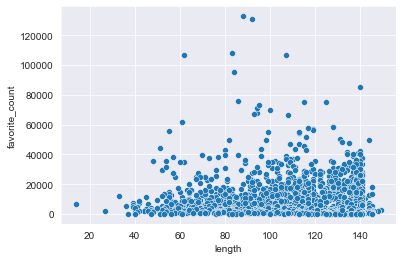

In [154]:
data['length'] = data.display_text_range.apply(lambda x: list(x)[1]+1)

sns.scatterplot("length","favorite_count",data=data);

The visualization above shows no strong trend between the length of a tweet and the likes the tweet received. The above chart shows there is no evidence of bias to like longer or shorter tweets. 

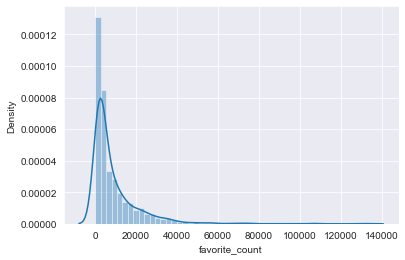

In [155]:
sns.distplot(data["favorite_count"]);

They rarely get more than 50000 likes